# Medición de tiempo con Python

El propósito de estos apuntes es presentar varias formas de medir el tiempo que toma una determinada función. Para esto se empleará una función que emplea múltiples bucles `for`.

In [1]:
import random

In [2]:
def func(a,b,c,d):
    s = 0
    for i in range(a):
        for j in range(b):
            for k in range(c):
                for l in range(d):
                    s += i*j*k*l
    return s

## Módulo time

In [3]:
import time

Este módulo proporciona varios métodos para medir tiempo, todos presentan un resolución de orden similar.

In [4]:
a = random.randrange(1,10)
b = random.randrange(1,10)
c = random.randrange(1,10)
d = random.randrange(1,10)

In [5]:
tic = time.time()
func(a,b,c,d)
toc = time.time()
print('tiempo de func con time.time %f'%(toc-tic))

tiempo de func con time.time 0.000167


In [6]:
tic = time.perf_counter()
func(a,b,c,d)
toc = time.perf_counter()
print('tiempo de func con time.perf_counter %f'%(toc-tic))

tiempo de func con time.perf_counter 0.000152


In [7]:
tic = time.process_time()
func(a,b,c,d)
toc = time.process_time()
print('tiempo de func con time.process_time %f'%(toc-tic))

tiempo de func con time.process_time 0.000112


Se observa que las mediciones realizadas tienen resultados muy parecidos. Para ver si hay muchas diferencias se van a realizar varias medidas, las cuales serán guardadas en una lista.

In [8]:
timelist = []
perflist = []
proclist = []
veces = 100

In [9]:
for i in range(veces):
    tic = time.time()
    func(a,b,c,d)
    toc = time.time()
    timelist.append(toc-tic)
    
    tic = time.perf_counter()
    func(a,b,c,d)
    toc = time.perf_counter()
    perflist.append(toc-tic)
 
    tic = time.process_time()
    func(a,b,c,d)
    toc = time.process_time()
    proclist.append(toc-tic)

Ahora se graficarán las mediciones

In [10]:
import matplotlib.pyplot as plt

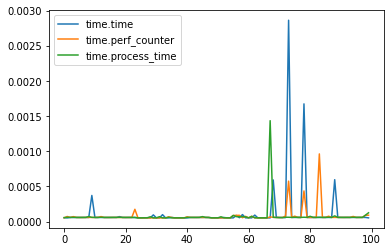

In [11]:
x = list(range(veces))
plt.plot(x,timelist,label='time.time')
plt.plot(x,perflist,label='time.perf_counter')
plt.plot(x,proclist,label='time.process_time')
plt.legend()

En la gráfica se observa que las tres curvas presentan, en general, la misma tendencia, pero con algunas distorsiones. ¿Cómo estará el promedio de los métodos de medición?

In [12]:
import statistics

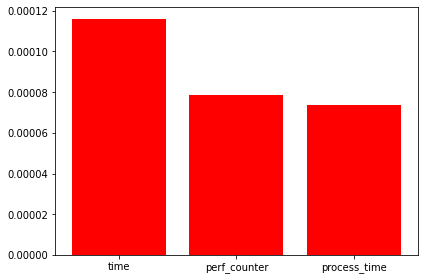

In [13]:
noms = ['time','perf_counter','process_time']
proms1 = [ 
    statistics.mean(timelist), 
    statistics.mean(perflist), 
    statistics.mean(proclist)
]
plt.bar(noms,proms1,color='r')
plt.tight_layout()

Se observa que todos los promedios están en el mismo orden de magnitud, pero que no son exactamente iguales a pesar de tratarse de la misma función, que la cantidad de pruebas es la misma y que los métodos de medición tienen una resolución similar. ¿Cuál podría ser la  causa de estas variaciones?

## Módulo timeit

El método timeit devuelve el tiempo acumulado luego de ejecutar la función indicada, la cantidad de veces en su opción `number`. Por esta razón, para obtener el tiempo promedio transcurrido se dividirá el resultado de `timeit` entre la cantidad de veces que se indique en `number`.

In [14]:
import timeit

In [15]:
setup = '''
from __main__ import func

import random

a = random.randrange(1,10)
b = random.randrange(1,10)
c = random.randrange(1,10)
d = random.randrange(1,10)
'''

In [16]:
stmt = '''
func(a,b,c,d)
'''

In [17]:
number = 10000
timeitres = timeit.timeit(
    setup = setup,
    stmt = stmt,
    number = number
)
print('tiempo de func con timeit.timeit %f'%(timeitres/number))

tiempo de func con timeit.timeit 0.000008


Para realizar varias repeticiones `timeit` proporciona el método `repeat` el cual devuelve una lista con la cantidad de veces indicada en la opción respectiva. Igual que en el caso anterior los resultados se tienen que dividir entre la cantidad de veces porque devuelve el tiempo acumulado.

In [18]:
repeat = 100
timeitreps = timeit.repeat(
    setup = setup,
    stmt = stmt,
    number = number,
    repeat = repeat
)
repeatlist = [t/number for t in timeitreps]

Ahora se procederá a hacer una gráfica de las mediciones

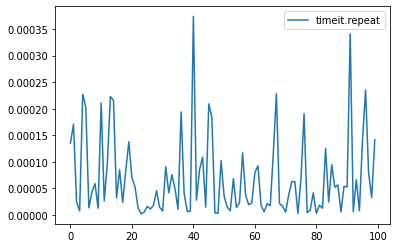

In [19]:
plt.plot(x,repeatlist,label='timeit.repeat')
plt.legend()

## Comparación de los módulos

Gráfica conjunta de las mediciones

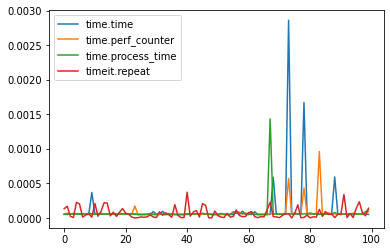

In [20]:
plt.plot(x,timelist,label='time.time')
plt.plot(x,perflist,label='time.perf_counter')
plt.plot(x,proclist,label='time.process_time')
plt.plot(x,repeatlist,label='timeit.repeat')
plt.legend()

Ahora se procederá a comparar el tiempo promedio de este método en comparación con los otros métodos

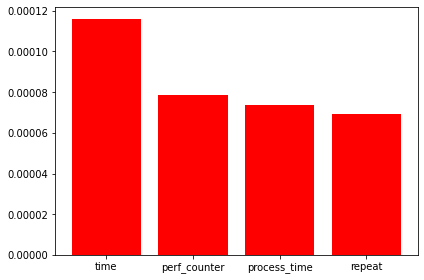

In [21]:
noms = ['time','perf_counter','process_time','repeat']
proms2 = [ 
    statistics.mean(timelist), 
    statistics.mean(perflist), 
    statistics.mean(proclist),
    statistics.mean(repeatlist)
]
plt.bar(noms,proms2,color='r')
plt.tight_layout()

Se observa que las mediciones realizadas con los métodos proporcionados por los dos módulos son irregulares, es decir, ambas mediciones presentan picos. Sumar estos picos que se ha introducido en nuestras mediciones y luego promediar implicaría que estas irregularidades están en cómputo del promedio y esto desviaría el resultado final de lo real. ¿Cómo medir esta distorsión? ¿Cómo eliminar el ruido?

## Filtro mediana unidimensional

El filtro de mediana es un algoritmo empleado para eliminar ruido.

In [22]:
def filtro_mediana(sign, ventana):
    signc = []
    tam = len(sign)
    offs = int((ventana-1)/2)
    for i in range(tam):
        inicio = i - offs if (i - offs > 0) else i
        fin = i + offs if (i + offs < tam) else tam
        signc.append(statistics.median(sign[inicio:fin]))
    return signc

In [23]:
ventana = 7
timelistsr = filtro_mediana(timelist,ventana)

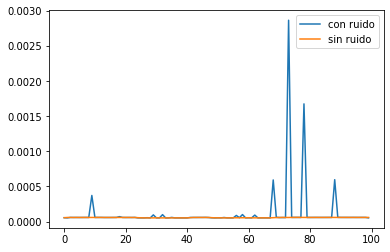

In [24]:
# gráfico de las mediciones realizadas con time.time con y sin ruido
plt.plot(x,timelist, label='con ruido')
plt.plot(x,timelistsr, label='sin ruido')
# para mostrar la leyenda
plt.legend()

In [25]:
perflistsr = filtro_mediana(perflist,ventana)

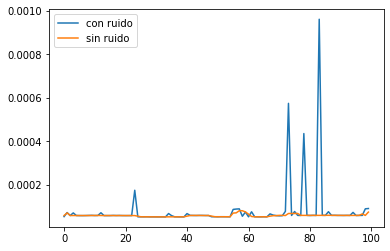

In [26]:
# gráfico de las mediciones realizadas con time.perf_counter con y sin ruido
plt.plot(x,perflist, label='con ruido')
plt.plot(x,perflistsr, label='sin ruido')
# para mostrar la leyenda
plt.legend()

In [27]:
proclistsr = filtro_mediana(proclist,ventana)

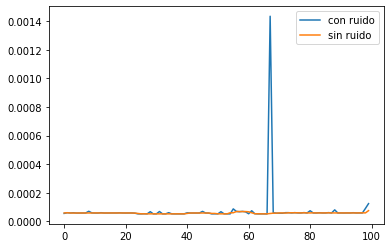

In [28]:
# gráfico de las mediciones realizadas con time.process_time con y sin ruido
plt.plot(x,proclist, label='con ruido')
plt.plot(x,proclistsr, label='sin ruido')
# para mostrar la leyenda
plt.legend()

In [29]:
repeatlistsr = filtro_mediana(repeatlist,ventana)

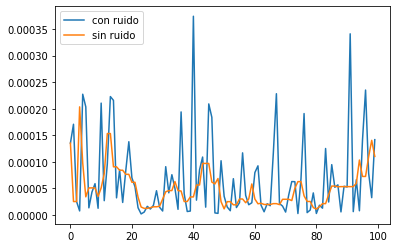

In [30]:
# gráfico de las mediciones realizadas con time.process_time con y sin ruido
plt.plot(x,repeatlist, label='con ruido')
plt.plot(x,repeatlistsr, label='sin ruido')
# para mostrar la leyenda
plt.legend()

¿Varían mucho los promedios luego de la eliminación del ruido?

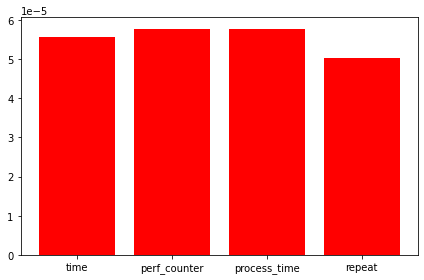

In [31]:
noms = ['time','perf_counter','process_time','repeat']
promssr = [ 
    statistics.mean(timelistsr), 
    statistics.mean(perflistsr), 
    statistics.mean(proclistsr),
    statistics.mean(repeatlistsr)
]
plt.bar(noms,promssr,color='r')
plt.tight_layout()

¿Qué impacto tuvo eliminar el ruido de las señales en el valor final de los promedios? ¿Fueron significativas las distorsiones introducidas en las mediciones? ¿Cuál es la diferencia entre el promedio con ruido y sin ruido? Se deja estas preguntas para su reflexión.

# Implementación de funciones

En esta sección de implementará una función que calcula la suma de números enteros desde el $1$ hasta el número anterior indicado en su argumento. Esta será implementada de múltiples formas con el propósito de mostrar como la implementación se puede traducir en tiempos de ejecución mayores o menores.

## Implementación while

In [32]:
def sumar_enteros_while(n=1_000_000):
    i = 0
    s = 0
    while (i < n):
        s += i
        i += 1
    return s

In [33]:
timeit.timeit(sumar_enteros_while,number=1)

0.0738159760076087

In [34]:
timeit.timeit(sumar_enteros_while,number=10)/10

0.06801344830018934

In [35]:
timeit.timeit(sumar_enteros_while,number=100)/100

0.06648918474005767

## Implementación for

In [36]:
def sumar_enteros_for(n=1_000_000):
    s = 0
    for i in range(n):
        s += i
    return s

In [37]:
timeit.timeit(sumar_enteros_for,number=1)

0.04685428400989622

In [38]:
timeit.timeit(sumar_enteros_for,number=10)/10

0.04275192659988534

In [39]:
timeit.timeit(sumar_enteros_for,number=100)/100

0.03867738870991161

Se observa que la función que emplea el bucle `for` es ligeramente más rápida que la función implementada con bucle `while`. Esto se debe a que la implementación con bucle `for` está más optimizada a nivel de ensamblador. Como ejemplo, se mostrará como afecta al rendimiento el añadir operaciones "triviales" o innecesarias. 

In [40]:
def sumar_enteros_for_incremento(n=1_000_000):
    s = 0
    c = 0
    for i in range(n):
        s += c
        c += 1
    return s

In [41]:
timeit.timeit(sumar_enteros_for_incremento,number=1)

0.07428878199425526

In [42]:
timeit.timeit(sumar_enteros_for_incremento,number=10)/10

0.06493422290077433

In [43]:
timeit.timeit(sumar_enteros_for_incremento,number=100)/100

0.0656103124297806

Bastó con incluir una operación de incremento para que el tiempo sea relativamente similar a la implementación con bucle `while`. 

In [44]:
def sumar_enteros_for_incremento_comp(n=1_000_000):
    s = 0
    c = 0
    for i in range(n):
        if i < n: 
            pass
        s += c
        c += 1
    return s

In [45]:
timeit.timeit(sumar_enteros_for_incremento_comp,number=1)

0.08810087401070632

In [46]:
timeit.timeit(sumar_enteros_for_incremento_comp,number=10)/10

0.07777486959821545

In [47]:
timeit.timeit(sumar_enteros_for_incremento_comp,number=100)/100

0.07839955051022116

Al añadir la operación de comparación la función ahora es incluso más lenta. Se debe tener en cuenta estos detalles para implementar funciones. Un camino alternativo, es emplear las funciones internas que proporciona el lenguaje.

## Con funciones internas

In [48]:
def sumar_enteros_idiomatic(n=1_000_000):
    return sum(range(n))

In [49]:
timeit.timeit(sumar_enteros_idiomatic,number=1)

0.01166107298922725

In [50]:
timeit.timeit(sumar_enteros_idiomatic,number=10)/10

0.012862062401836738

In [51]:
timeit.timeit(sumar_enteros_idiomatic,number=100)/100

0.011840317799942568

Se observa que las funciones internas de Python ya están muy optimizadas y lo recomendable es emplearlas si están disponibles.

## Comparación de las funciones implementadas

Se definen funciones con lo aprendido para poder usarlo de forma modular

In [52]:
def medir_timeit(f,veces):
    timeits = []
    t = 0
    for i in range(veces):
        t = timeit.timeit(f,number=1)
        timeits.append(t)
    return timeits

In [53]:
def medir_time(f,veces):
    times = []
    tic = 0
    toc = 0
    e = 0
    for i in range(veces):
        tic = time.time()
        f()
        toc = time.time()
        e = toc - tic
        times.append(e)
    return times

Mediciones con timeit

In [54]:
t1 = medir_timeit(sumar_enteros_while,100)

In [55]:
t2 = medir_timeit(sumar_enteros_for,100)

In [56]:
t3 = medir_timeit(sumar_enteros_for_incremento,100)

In [57]:
t4 = medir_timeit(sumar_enteros_for_incremento_comp,100)

In [58]:
t5 = medir_timeit(sumar_enteros_idiomatic,100)

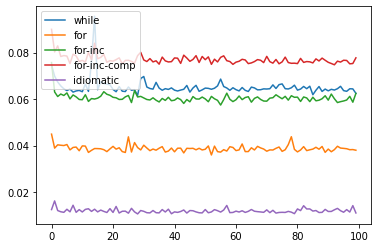

In [59]:
x = range(len(t1))
plt.plot(x,t1, label='while')
plt.plot(x,t2, label='for')
plt.plot(x,t3, label='for-inc')
plt.plot(x,t4, label='for-inc-comp')
plt.plot(x,t5, label='idiomatic')
# para mostrar la leyenda
plt.legend()

Luego de pasar filtro mediano a las mediciones

In [60]:
t1c = filtro_mediana(t1, 7)

In [61]:
t2c = filtro_mediana(t2, 7)

In [62]:
t3c = filtro_mediana(t3, 7)

In [63]:
t4c = filtro_mediana(t4, 7)

In [64]:
t5c = filtro_mediana(t5, 7)

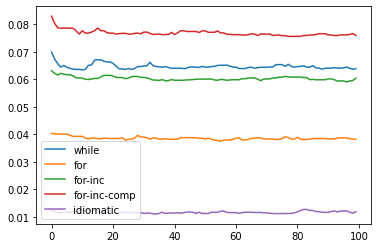

In [65]:
plt.plot(x,t1c, label='while')
plt.plot(x,t2c, label='for')
plt.plot(x,t3c, label='for-inc')
plt.plot(x,t4c, label='for-inc-comp')
plt.plot(x,t5c, label='idiomatic')
# para mostrar la leyenda
plt.legend()

Mediciones con time

In [66]:
r1 = medir_time(sumar_enteros_while,100)

In [67]:
r2 = medir_time(sumar_enteros_for,100)

In [68]:
r3 = medir_time(sumar_enteros_for_incremento,100)

In [69]:
r4 = medir_time(sumar_enteros_for_incremento_comp,100)

In [70]:
r5 = medir_time(sumar_enteros_idiomatic,100)

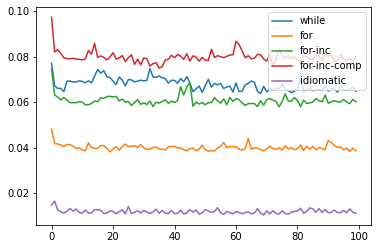

In [71]:
plt.plot(x,r1, label='while')
plt.plot(x,r2, label='for')
plt.plot(x,r3, label='for-inc')
plt.plot(x,r4, label='for-inc-comp')
plt.plot(x,r5, label='idiomatic')
# para mostrar la leyenda
plt.legend()

Luego de pasar filtro mediano a las mediciones

In [72]:
r1c = filtro_mediana(r1, 7)

In [73]:
r2c = filtro_mediana(r2, 7)

In [74]:
r3c = filtro_mediana(r3, 7)

In [75]:
r4c = filtro_mediana(r4, 7)

In [76]:
r5c = filtro_mediana(r5, 7)

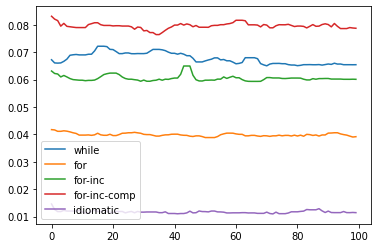

In [77]:
plt.plot(x,r1c, label='while')
plt.plot(x,r2c, label='for')
plt.plot(x,r3c, label='for-inc')
plt.plot(x,r4c, label='for-inc-comp')
plt.plot(x,r5c, label='idiomatic')
# para mostrar la leyenda
plt.legend()

Gráficos de barras

<BarContainer object of 5 artists>

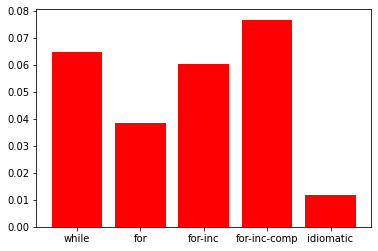

In [78]:
x = ['while','for','for-inc','for-inc-comp','idiomatic']
# promedios
proms = [
    statistics.mean(t1c),
    statistics.mean(t2c),
    statistics.mean(t3c),
    statistics.mean(t4c),
    statistics.mean(t5c)
]
# gráfico de barras
plt.bar(x,proms,color='r')

<BarContainer object of 5 artists>

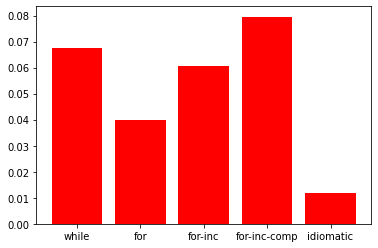

In [79]:
# promedios sin ruido
promssr = [
    statistics.mean(r1c),
    statistics.mean(r2c),
    statistics.mean(r3c),
    statistics.mean(r4c),
    statistics.mean(r5c)
]
# gráfico de barras
plt.bar(x,promssr,color='r')

Los resultados fueron obtenidos al ejecutar el cuaderno en una máquina virtual con cuatro núcleos y 4GB de RAM. Por esta razón, usted podría obtener resultados muy diferentes al ejecutarlo en su equipo.